## % - to - Weights

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  


def calculate_wrr_weights(data_link_rate, percentage_times, average_packet_sizes):
    weights = []

    # Calculate weights for each queue
    for time, size in zip(percentage_times, average_packet_sizes):
        weight =  (time/100)*(data_link_rate/8) / size
        # print(weight)
        weights.append(weight)

    # Normalize weights
    total_weight = sum(weights)
    normalized_weights = [weight / total_weight for weight in weights]

    return normalized_weights

# Example parameters
data_link_rate = 52.49e9  # Gbps
# DL - 18.99 ; 20
percentage_times = [26,17,19,38]  # Percentages for Queue 1, Queue 2, Queue 3
# average_packet_sizes = [972.13, 92, 269]  # Average packet sizes for Queue 1, Queue 2, Queue 3
average_packet_sizes = [1464,160,1358 ,1450]  # Average packet sizes for Queue 1, Queue 2, Queue 3

# Calculate WRR weights
wrr_weights = calculate_wrr_weights(data_link_rate, percentage_times, average_packet_sizes)
print("WRR Weights:", np.multiply(wrr_weights,100))


WRR Weights: [10.81530963 64.7046697   8.52041046 15.95961021]


FileNotFoundError: [Errno 2] No such file or directory: './sim_results/boxplot_coordinates_U-Plane.txt'

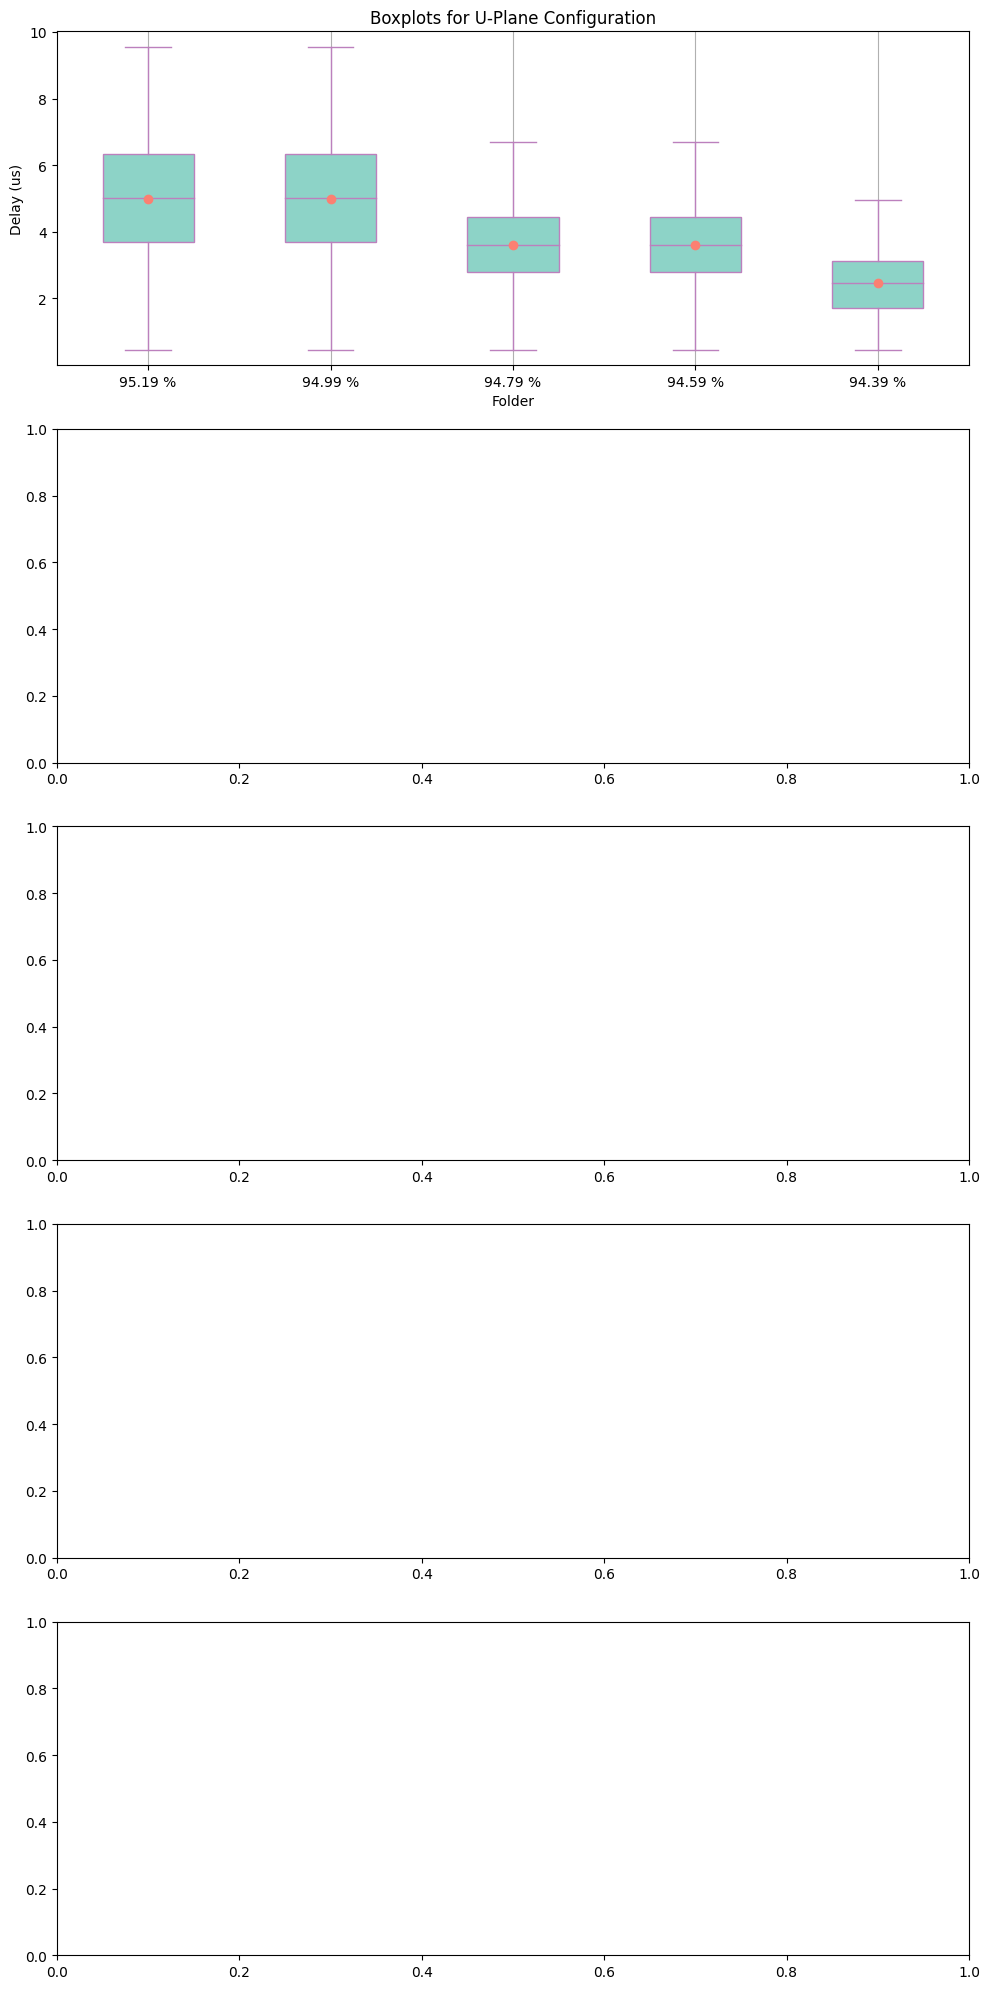

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

# Set a custom color palette
colors = plt.cm.Set3.colors

plt.rcParams["figure.autolayout"] = True


# Define parameters
agregado = 52.49
Start = 55.14
Stop = 55.3
Step = 0.04
Cap_swept = np.arange(Start, Stop+(Step/2), Step, dtype=float)  
Type_of_combis = ["MOD_DL_UPandLowSep_CU-plane"]
folders = [f"../sim_results/{name_combi}_20M_{cap:.2f}/" for name_combi in Type_of_combis for cap in Cap_swept]







Flow_min_value = 1
Flow_max_value = 4
RU = 3
Step = 1
configs_txt = ["U-Plane", "C-Plane", "URLLC-RC", "URLLC-DA", "eMBB"]
Flows = np.arange(1, Flow_max_value + Step, Step)
Ru = np.arange(1, RU + Step, Step)
AAUs = np.arange(1, 13, 1)
Nsim = 1

def process_folder(folder):
    delay = []
    delay_aux = [] 
    delay_us = []
    delay_control = []
    delay_user = []
    delay_rt = []

    for flow in Flows:
        if flow == 1:
            for ru in Ru:
                CTx = pd.read_csv(f"{folder}TxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                UTx = pd.read_csv(f"{folder}TxFileUser{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                CRx = pd.read_csv(f"{folder}RxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                URx = pd.read_csv(f"{folder}RxFileUser{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])

                min_len = min(len(UTx), len(URx))
                delay_user.append(URx["Time"].values[:min_len] - UTx["Time"].values[:min_len])
                min_len = min(len(CTx), len(CRx))
                delay_control.append(CRx["Time"].values[:min_len] - CTx["Time"].values[:min_len])

            delay.append(np.concatenate(delay_user))
            delay.append(np.concatenate(delay_control))
        else: 
            delay_rt = []
            for num in AAUs:
                Tx = pd.read_csv(f"{folder}TxFile{num-1 + 12*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                Rx = pd.read_csv(f"{folder}RxFile{num-1 + 12*(flow-2)}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                min_len = min(len(Tx), len(Rx))
                delay_rt.append( Rx["Time"].values[:(min_len-1)] - Tx["Time"].values[:(min_len-1)])

            delay.append(np.concatenate(delay_rt))

    delay_us = [arr*1e-9 for arr in delay]    
    return delay_us






# Process data for each folder
delay_us_dict = {}
for folder in folders:
    delay_us_dict[folder] = process_folder(folder)


# Plot all boxplots in the same figure
fig, axes = plt.subplots(nrows=len(configs_txt), ncols=1, figsize=(10, 20))

for i, config in enumerate(configs_txt):
    ax = axes[i]
    # Collect delay data for this configuration label from all folders
   
    data = [delay_us_dict[folder][i] for folder in folders]
    # Plot boxplots for this configuration label
    bp = ax.boxplot(
        data,
        labels=[f"{((agregado/Start)*100)-0.2*(j):.2f} %" for j in range(len(folders))],
        showmeans=True,
        showfliers=False,
        patch_artist=True,  # fill with color
        boxprops=dict(facecolor=colors[0], color=colors[9]),
        capprops=dict(color=colors[9]),
        whiskerprops=dict(color=colors[9]),
        flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
        medianprops=dict(color=colors[9]),
        meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
    )
    ax.set_title(f"Boxplots for {config} Configuration")
    
    ax.set_ylabel("Delay (us)")
    ax.set_xlabel("Folder")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.grid()

    # Extracting boxplot information
    lw = [item.get_ydata()[1] for item in bp['whiskers'][::2]]
    lq = [item.get_ydata()[0] for item in bp['whiskers'][::2]]
    med = [item.get_ydata()[1] for item in bp['medians']]
    uq = [item.get_ydata()[0] for item in bp['whiskers'][1::2]]
    uw = [item.get_ydata()[1] for item in bp['whiskers'][1::2]]
    xaux = range(len(folders))
    avg = [item.get_ydata()[0] for item in bp['means']]

    # Write to a text file
    with open(f"../sim_results/boxplot_coordinates_{config.replace(' ', '_')}.txt", "w") as f:
        f.write("lw\tlq\tmed\tuq\tuw\txaux\tavg\n")
        for lw_val, lq_val, med_val, uq_val, uw_val, xaux_val, avg_val in zip(lw, lq, med, uq, uw, xaux, avg):
            f.write(f"{lw_val}\t{lq_val}\t{med_val}\t{uq_val}\t{uw_val}\t{xaux_val}\t{avg_val}\n")

plt.tight_layout()
plt.show()
